In [1]:
import csv

In [2]:
import imageio
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import os
import matplotlib.pyplot as plt
%matplotlib inline

#### Model directory

In [3]:
model_dir = 'data/models/test7/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Load recorded images and steering data

In [4]:
right_camera_offset = -0.27
left_camera_offset = 0.23

In [5]:
def load_images(data_dir, discard_prob):
    df = pd.read_csv(data_dir+'driving_log.csv')
    images = []
    measurements = []

    def fetch_image(data_dir, source_path):
        filename = source_path.split('/')[-1]
        current_path = data_dir + 'IMG/' + filename
        return imageio.imread(current_path)

    def append_image(image, measurement):
        images.append(image)
        measurements.append(measurement)

        # flip image
        image_flipped = np.fliplr(image)
        measurement_flipped = -measurement
        images.append(image_flipped)
        measurements.append(measurement_flipped)

    for idx, row in df.iterrows():
        measurement = float(row[3])
        if measurement <= 0 and np.random.rand() < discard_prob:
            continue
            
        center_image = fetch_image(data_dir, row[0])
        append_image(center_image, measurement)
        
        left_image = fetch_image(data_dir, row[1])
        append_image(left_image, measurement+left_camera_offset)
        
        right_image = fetch_image(data_dir, row[2])
        append_image(right_image, measurement+right_camera_offset)
        
    return images, measurements
    
def load_from_dir(data_dir, discard_prob=0, load_cached=True):
    if load_cached and os.path.exists(data_dir+'X_train.npy'):
        X_train = np.load(data_dir+'X_train.npy')
        y_train = np.load(data_dir+'y_train.npy')
    else:
        images, measurements = load_images(data_dir, discard_prob)
        
        X_train = np.array(images)
        y_train = np.array(measurements)

        np.save(data_dir+'X_train.npy', X_train)
        np.save(data_dir+'y_train.npy', y_train)
    
    print('X_train:', X_train.shape)
    print('y_train:', y_train.shape)
    return X_train, y_train
    

### Load Recorded data sets

In [ ]:
# 1. sample data
X_train_sample, y_train_sample = load_from_dir('data/sample_data/', discard_prob=0.7)

In [ ]:
# 2. Dirt road where vehicle messed up
X_train_dirt, y_train_dirt = load_from_dir('data/recorded_data/lap1_dirt_bridge/', discard_prob=0)

In [ ]:
# 3. Correcting car from out of bounds
X_train_mis, y_train_mis = load_from_dir('data/recorded_data/lap1mistakes/', discard_prob=0.5)

In [ ]:
# 4. Just 1 Lap
X_train_lap1, y_train_lap1 = load_from_dir('data/recorded_data/lap1/', discard_prob=0.5)

In [ ]:
# 5. 1 Lap in reverse
X_train_rev, y_train_rev = load_from_dir('data/recorded_data/lap1reverse/', discard_prob=0.5)

### Combine all the records into one training set

In [ ]:
X_train_all = np.concatenate([X_train_sample, X_train_dirt, X_train_mis, X_train_lap1, X_train_rev])
y_train_all = np.concatenate([y_train_sample, y_train_dirt, y_train_mis, y_train_lap1, y_train_rev])
np.save('data/all/'+'X_train_all.npy', X_train_all)
np.save('data/all/'+'y_train_all.npy', y_train_all)

In [6]:
X_train_all = np.load('data/all/'+'X_train_all.npy')
y_train_all = np.load('data/all/'+'y_train_all.npy')

In [7]:
print(X_train_all.shape)
print(y_train_all.shape)

(52194, 160, 320, 3)
(52194,)


### Create Model

In [8]:
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, BatchNormalization, Input, Dropout

Using TensorFlow backend.


### NVIDIA Suggested network

In [9]:
model = Sequential()
model.add(Lambda(lambda x: x - 255.0 / 255.0, input_shape=(160,320,3)))
model.add(BatchNormalization(axis=1))
model.add(keras.layers.Convolution2D(24, (5,5), strides=(2,2), activation='relu'))
model.add(keras.layers.Convolution2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(keras.layers.Convolution2D(48, (5,5), strides=(2,2), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(keras.layers.Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(keras.layers.Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

In [10]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.001))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 320, 3)       640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 37, 48)        43248     
_________________________________________________________________
batch_normalization_2 (Batch (None, 17, 37, 48)        68        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 35, 64)        27712     
__________

### First run

In [12]:
history_object = model.fit(X_train_all, y_train_all, validation_split=0.2, shuffle=True, epochs=7)
model.save(model_dir+'nvidia_suggested_model.h5')

Train on 41755 samples, validate on 10439 samples
Epoch 1/7
41755/41755 [==============================] - 97s - loss: 0.1651 - val_loss: 0.0115
Epoch 2/7
41755/41755 [==============================] - 94s - loss: 0.0271 - val_loss: 0.0033
Epoch 3/7
41755/41755 [==============================] - 94s - loss: 0.0169 - val_loss: 0.0026
Epoch 4/7
41755/41755 [==============================] - 94s - loss: 0.0136 - val_loss: 0.0039
Epoch 5/7
41755/41755 [==============================] - 94s - loss: 0.0127 - val_loss: 0.0021
Epoch 6/7
41755/41755 [==============================] - 94s - loss: 0.0116 - val_loss: 0.0019
Epoch 7/7
41755/41755 [==============================] - 94s - loss: 0.0112 - val_loss: 0.0021


### Visualizing training loss

dict_keys(['val_loss', 'loss'])


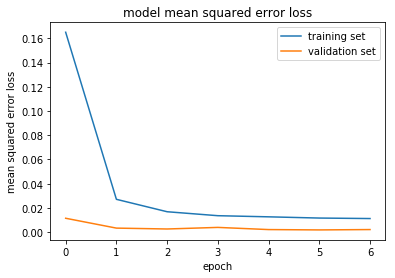

In [13]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Additional runs

In [ ]:
# model = keras.models.load_model(model_dir+'nvidia_suggested_model.h5')
model.optimizer.lr.assign(0.005)
model.fit(X_train_all, y_train_all, validation_split=0.2, shuffle=True, epochs=3)

model.save(model_dir+'nvidia_suggested_model_2.h5')

In [ ]:
# model = keras.models.load_model(model_dir+'nvidia_suggested_model_2.h5')
model.optimizer.lr.assign(0.0001)
model.fit(X_train_all, y_train_all, validation_split=0.2, shuffle=True, epochs=2)

model.save(model_dir+'nvidia_suggested_model_3.h5')

### Dirt roads

In [ ]:
X_train_dirt, y_train_dirt = load_from_dir('data/recorded_data/lap1_dirt_bridge/', discard_prob=0, load_cached=False)
# model = keras.models.load_model('data/sample_data/'+'nvidia_suggested_model.h5')

In [ ]:
plt.imshow(X_train_dirt[2200])
print(y_train_dirt[2200])

In [ ]:
model.optimizer.lr.assign(0.0001)
model.fit(X_train_dirt, y_train_dirt, validation_split=0.1, shuffle=True, epochs=7)

model.save(model_dir+'nvidia_suggested_model_dirt.h5')

In [ ]:
model.optimizer.lr.assign(0.00005)
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=2)

model.save(model_dir+'nvidia_suggested_model_dirt2.h5')

### Select images from each bucket for testing

In [ ]:
y_train[:30]

In [ ]:
print(y_train[2])
plt.imshow(X_train[2])

### Additional data

In [ ]:
X_train, y_train = load_from_dir('data/recorded_data/lap1/', [0, 1, 2], False)

In [ ]:
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=7)

model.save(model_dir+'nvidia_suggested_model_self_lap1.h5')

### Lap1 Mistakes

In [ ]:
X_train, y_train = load_from_dir('data/recorded_data/lap1mistakes/', [0, 1, 2], False)

In [ ]:
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=6)

model.save(model_dir+'nvidia_suggested_model_self_lap1mistakes.h5')

### Lap1 Reverse

In [ ]:
X_train, y_train = load_from_dir('data/recorded_data/lap1reverse/', [0, 1, 2], False)

In [ ]:
# model.optimizer.lr = 0.001
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)

model.save(model_dir+'nvidia_suggested_model_self_lap1reverse.h5')